In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [56]:
df_train  = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col='id')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col='id')
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [57]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [58]:
df_test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [59]:
print('Train size:', df_train.shape)
print('Test size', df_test.shape)

Train size: (58645, 12)
Test size (39098, 11)


In [60]:
target = 'loan_status'

## Handling Missing Values

In [61]:
df_train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [62]:
df_test.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [63]:
df_train['loan_int_rate'] = df_train['loan_int_rate'].fillna(df_train['loan_int_rate'].mean())
df_train['person_emp_length'] = df_train['person_emp_length'].fillna(df_train['person_emp_length'].mean())

## Removing Duplicate Data

In [64]:
df_train.duplicated().sum()

0

In [65]:
df_train.drop_duplicates(inplace=True)

## Preprocess string features

In [66]:
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df_train, df_test):  
    label_enc = LabelEncoder()   
    label_cols = ['person_home_ownership', 'loan_grade', 'cb_person_default_on_file']    
    for col in label_cols:
        df_train[col] = label_enc.fit_transform(df_train[col])
        df_test[col] = label_enc.transform(df_test[col])    
    df_train = pd.get_dummies(df_train, columns=['loan_intent'], drop_first=True)
    df_test = pd.get_dummies(df_test, columns=['loan_intent'], drop_first=True) 
    target_col = 'loan_status'
    train_columns = df_train.drop(columns=[target_col]).columns    
    df_test = df_test.reindex(columns=train_columns, fill_value=0)    
    return df_train, df_test

df_train, df_test = preprocess_data(df_train, df_test)

## Feature Engineering

In [67]:
def feature_engineering(df):
    df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']  
    df['financial_burden'] = df['loan_amnt'] * df['loan_int_rate'] 
    df['income_per_year_emp'] = df['person_income'] / (df['person_emp_length'])
    df['cred_hist_to_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']
    df['int_to_loan_ratio'] = df['loan_int_rate'] / df['loan_amnt']
    df['loan_int_emp_interaction'] = df['loan_int_rate'] * df['person_emp_length']
    df['debt_to_credit_ratio'] = df['loan_amnt'] / df['cb_person_cred_hist_length'] 
    df['int_to_cred_hist'] = df['loan_int_rate'] / df['cb_person_cred_hist_length']  
    df['int_per_year_emp'] = df['loan_int_rate'] / (df['person_emp_length'])
    df['loan_amt_per_emp_year'] = df['loan_amnt'] / (df['person_emp_length'])      
    df['income_to_loan_ratio'] = df['person_income'] / df['loan_amnt']     
    return df

df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)

In [68]:
df_train.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_grade', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_to_income_ratio',
       'financial_burden', 'income_per_year_emp', 'cred_hist_to_age_ratio',
       'int_to_loan_ratio', 'loan_int_emp_interaction', 'debt_to_credit_ratio',
       'int_to_cred_hist', 'int_per_year_emp', 'loan_amt_per_emp_year',
       'income_to_loan_ratio'],
      dtype='object')

In [69]:
df_test.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_grade', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_to_income_ratio',
       'financial_burden', 'income_per_year_emp', 'cred_hist_to_age_ratio',
       'int_to_loan_ratio', 'loan_int_emp_interaction', 'debt_to_credit_ratio',
       'int_to_cred_hist', 'int_per_year_emp', 'loan_amt_per_emp_year',
       'income_to_loan_ratio'],
      dtype='object')

## Removing Inf values

In [70]:
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train.fillna(df_train.mean(), inplace=True)
print("DataFrame after replacing inf with column means:")
df_train.head()

DataFrame after replacing inf with column means:


,person_age,person_income,person_home_ownership,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,...,financial_burden,income_per_year_emp,cred_hist_to_age_ratio,int_to_loan_ratio,loan_int_emp_interaction,debt_to_credit_ratio,int_to_cred_hist,int_per_year_emp,loan_amt_per_emp_year,income_to_loan_ratio
id,,,,,,,,,,,,,,,,,,,,,
0,37,35000,3,0.0,1,6000,11.49,0.17,0,14,...,68940.0,19429.217074,0.378378,0.001915,0.00,428.571429,0.820714,3.437667,2847.922657,5.833333
1,22,56000,2,6.0,2,4000,13.35,0.07,0,2,...,53400.0,9333.333333,0.090909,0.003337,80.10,2000.000000,6.675000,2.225000,666.666667,14.000000
2,29,28800,2,8.0,0,6000,8.90,0.21,0,10,...,53400.0,3600.000000,0.344828,0.001483,71.20,600.000000,0.890000,1.112500,750.000000,4.800000
3,30,70000,3,14.0,1,12000,11.11,0.17,0,5,...,133320.0,5000.000000,0.166667,0.000926,155.54,2400.000000,2.222000,0.793571,857.142857,5.833333
4,22,60000,3,2.0,0,6000,6.92,0.10,0,3,...,41520.0,30000.000000,0.136364,0.001153,13.84,2000.000000,2.306667,3.460000,3000.000000,10.000000


In [71]:
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.fillna(df_test.mean(), inplace=True)
print("DataFrame after replacing inf with column means:")
df_test.head()

DataFrame after replacing inf with column means:


,person_age,person_income,person_home_ownership,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,...,financial_burden,income_per_year_emp,cred_hist_to_age_ratio,int_to_loan_ratio,loan_int_emp_interaction,debt_to_credit_ratio,int_to_cred_hist,int_per_year_emp,loan_amt_per_emp_year,income_to_loan_ratio
id,,,,,,,,,,,,,,,,,,,,,
58645,23,69000,3,3.0,5,25000,15.76,0.36,0,2,...,394000.0,23000.0,0.086957,0.000630,47.28,12500.0,7.880000,5.253333,8333.333333,2.760000
58646,26,96000,0,6.0,2,10000,12.68,0.10,1,4,...,126800.0,16000.0,0.153846,0.001268,76.08,2500.0,3.170000,2.113333,1666.666667,9.600000
58647,26,30000,3,5.0,4,4000,17.19,0.13,1,2,...,68760.0,6000.0,0.076923,0.004298,85.95,2000.0,8.595000,3.438000,800.000000,7.500000
58648,33,50000,3,4.0,0,7000,8.90,0.14,0,7,...,62300.0,12500.0,0.212121,0.001271,35.60,1000.0,1.271429,2.225000,1750.000000,7.142857
58649,26,102000,0,8.0,3,15000,16.32,0.15,1,4,...,244800.0,12750.0,0.153846,0.001088,130.56,3750.0,4.080000,2.040000,1875.000000,6.800000


In [72]:
y = df_train[target]
df_train.drop(target, axis=1, inplace=True)
X = df_train

# Baseline
####  Baseline using CatBoost with K-Fold Cross Validation. Metric is ROC-AUC

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

catboost_params = {
    'depth': 7,
    'learning_rate': 0.19893301995319765,
    'bagging_temperature': 0.7979373495258176,
    'l2_leaf_reg': 5,
    'loss_function': 'Logloss',
    'iterations': 400,
    'grow_policy': 'Lossguide',
    'eval_metric': 'AUC',
}

n_splits = 10
skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

catboost_predictions = np.zeros(len(df_train))
catboost_true_labels = np.zeros(len(df_train))
catboost_test_predictions = np.zeros(len(df_test))

for fold, (train_idx, val_idx) in enumerate(skfold.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    catboost_model = CatBoostClassifier(**catboost_params)
    catboost_model.fit(X_train, y_train,
                       eval_set=(X_val, y_val),
                       early_stopping_rounds=10)
  
    catboost_fold_preds = catboost_model.predict_proba(X_val)[:, 1]  
    catboost_fold_test_preds = catboost_model.predict_proba(df_test)[:, 1]  
    catboost_predictions[val_idx] = catboost_fold_preds
    catboost_true_labels[val_idx] = y_val    
    catboost_test_predictions += catboost_fold_test_preds / n_splits
overall_metric_catboost = roc_auc_score(catboost_true_labels, catboost_predictions)
print("Overall AUC (CatBoostClassifier with StratifiedKFold):", overall_metric_catboost)

## Baseline ROC-AUC Curve

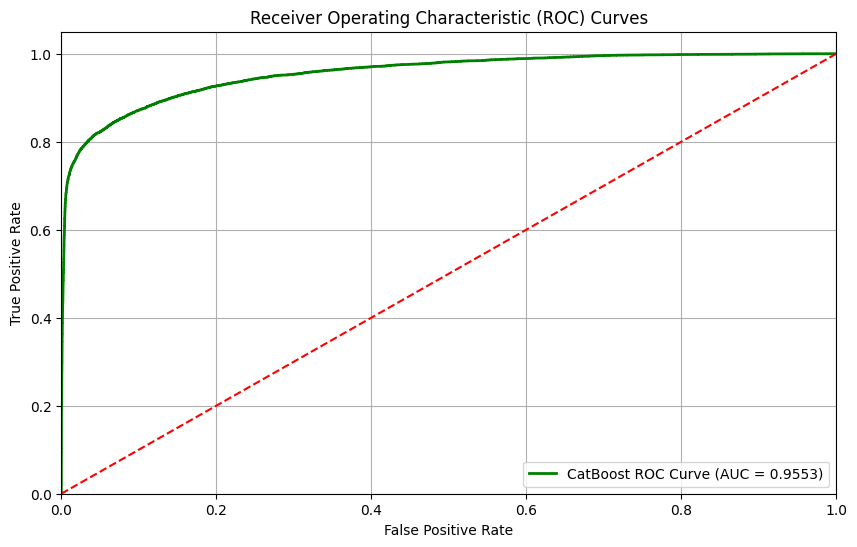

In [74]:
from sklearn.metrics import roc_curve, auc

fpr_catboost, tpr_catboost, _ = roc_curve(catboost_true_labels, catboost_predictions)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

plt.figure(figsize=(10, 6))
plt.plot(fpr_catboost, tpr_catboost, color='green', lw=2, label=f'CatBoost ROC Curve (AUC = {roc_auc_catboost:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Stacking with 3 models
#### Stacking using XGBClassifier, CatBoostClassifier and LGBMClassifier

In [75]:
skfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [76]:
train_preds = {}
test_preds = {}

In [77]:
categorical_features = df_train.select_dtypes(include='object').columns.tolist()

In [78]:
categorical_features = df_train.select_dtypes(include='object').columns.tolist()

## XGB Training

In [79]:
from xgboost import XGBClassifier, XGBRFClassifier, DMatrix

X_xgb = X.copy()
X_xgb[categorical_features] = X_xgb[categorical_features].astype('category')

test_xgb = df_test.copy()
test_xgb[categorical_features] = test_xgb[categorical_features].astype('category')

oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))


xgb_params = {
    'eval_metric': 'auc',
    'n_estimators': 5000,
    'learning_rate': 0.10999995057648126,
    'max_depth': 8,
    'subsample': 0.9999999999999999,
    'colsample_bytree': 0.49681888251576845,
    'reg_alpha': 8.919028743833996e-06,
    'reg_lambda': 9.999999999999998,
    'gamma': 0.09787383664032377,
    'min_child_weight': 1.0,
    'max_bin': 262143,
#     'tree_method': 'hist',
    'device': 'cuda',
    'enable_categorical': True,
    'early_stopping_rounds': 100,
}

for fold, (train_idx, test_idx) in enumerate(skfold.split(X_xgb, y)):
    X_train, y_train = X_xgb.iloc[train_idx], y[train_idx]
    X_test, y_test = X_xgb.iloc[test_idx], y[test_idx]
    
    xgb_clf = XGBClassifier(**xgb_params)
    xgb_clf = xgb_clf.fit(X_train, y_train,
                          eval_set=[(X_test, y_test)],
                          verbose=0)
    
    booster = xgb_clf.get_booster()
    oof_train_preds[test_idx] = booster.predict(DMatrix(X_test, enable_categorical=True),
                                               iteration_range=(0, xgb_clf.best_iteration + 1))
    test_pred = booster.predict(DMatrix(test_xgb, enable_categorical=True),
                                iteration_range=(0, xgb_clf.best_iteration + 1))
    auc = xgb_clf.best_score
    oof_aucs.append(auc)
    oof_preds.append(test_pred)
    print(f"Fold {fold+1} --> ROC-AUC Score: {auc:.6f}")

auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\nAverage Fold ROC-AUC Score: {auc_mean:.6f} \xB1 {auc_std:.6f}\n")

train_preds['xgb'] = oof_train_preds
test_pred_xgb = np.mean(oof_preds, axis=0)
test_preds['xgb'] = test_pred_xgb

Fold 1 --> ROC-AUC Score: 0.953776
Fold 2 --> ROC-AUC Score: 0.956048
Fold 3 --> ROC-AUC Score: 0.955586
Fold 4 --> ROC-AUC Score: 0.955024

Average Fold ROC-AUC Score: 0.955109 ± 0.000850



## CatBoost Training

In [80]:
from catboost import CatBoostClassifier, Pool

oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))

cat_params={
    'task_type'           : "CPU",
    'loss_function'       : 'Logloss',
    'eval_metric'         : "AUC",
    'bagging_temperature' : 0.25,
    'colsample_bylevel'   : 0.40,
    'iterations'          : 5_000,
    'learning_rate'       : 0.045,
    'max_depth'           : 7,
    'l2_leaf_reg'         : 0.80,
    'min_data_in_leaf'    : 30,
    'random_strength'     : 0.25,
    'random_state'        : 42,
    'early_stopping_rounds': 200,
    'use_best_model'       : True,
    'allow_writing_files' : False,
} # parameters are taken from https://www.kaggle.com/code/martynovandrey/eda-and-lgb-cat-xgb

features = df_train.columns.tolist()
def convert_to_string(df):
    df_cat = df.copy()
    df_cat = df_cat.fillna(0)
    for col in features:
        df_cat[col] = df_cat[col].astype('string')
    return df_cat

X_cat = convert_to_string(X)
test_cat = convert_to_string(df_test)

test_pool = Pool(test_cat, cat_features=features)

for fold, (train_idx, test_idx) in enumerate(skfold.split(X_cat, y)):
    X_train, y_train = X_cat.iloc[train_idx], y[train_idx]
    X_test, y_test = X_cat.iloc[test_idx], y[test_idx]
    
    X_train_pool = Pool(X_train, y_train, cat_features=features)
    X_test_pool = Pool(X_test, y_test, cat_features=features)
    
    cat_clf = CatBoostClassifier(**cat_params)
    cat_clf = cat_clf.fit(X=X_train_pool,
                          eval_set=X_test_pool,
                          verbose=0,
                          early_stopping_rounds=200)
    oof_train_preds[test_idx] = cat_clf.predict_proba(Pool(X_test, cat_features=features))[:, 1]
    test_pred = cat_clf.predict_proba(test_pool)[:, 1]
    
    oof_preds.append(test_pred)
    auc = cat_clf.best_score_['validation']['AUC']
    oof_aucs.append(auc)
    print(f"\nFold {fold+1}--> ROC-AUC Score: {auc:.6f}\n")

auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\nAverage Fold ROC-AUC Score: {auc_mean:.6f} \xB1 {auc_std:.6f}\n")

train_preds['cat'] = oof_train_preds
test_pred_cat = np.mean(oof_preds, axis=0)
test_preds['cat'] = test_pred_cat


Fold 1--> ROC-AUC Score: 0.960914


Fold 2--> ROC-AUC Score: 0.965646


Fold 3--> ROC-AUC Score: 0.965611


Fold 4--> ROC-AUC Score: 0.962818


Average Fold ROC-AUC Score: 0.963747 ± 0.001998



## LGB Training

In [81]:
from lightgbm import LGBMClassifier, early_stopping

oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))

lgb_params = {
    'n_estimators': 3000,
    "verbosity": -1,
    'depth': 15,
    "eval_metric": "auc",
    "max_bin": 262143,
    'num_leaves': 223,
    'learning_rate': 0.01, 
    'min_child_samples': 54,
    'subsample': 0.5395472919165504,
    'colsample_bytree': 0.547518064129546,
    'lambda_l1': 3.4444245446562,
    'lambda_l2': 2.87490408088595e-05,
    'enable_categorical': True,
}

for fold, (train_idx, test_idx) in enumerate(skfold.split(X_xgb, y)):
    X_train, y_train = X_xgb.iloc[train_idx], y[train_idx]
    X_test, y_test = X_xgb.iloc[test_idx], y[test_idx]
    
    lgb_clf = LGBMClassifier(**lgb_params)
    lgb_clf = lgb_clf.fit(X_train, y_train,
                          eval_set=[(X_test, y_test)],
                          eval_metric='auc',
                          callbacks=[early_stopping(100)])
    y_pred = lgb_clf.predict_proba(X_test, num_iteration=lgb_clf.best_iteration_)[:,1]
    auc = roc_auc_score(y_test, y_pred)
    oof_aucs.append(auc)
    oof_train_preds[test_idx] = y_pred
    oof_preds.append(lgb_clf.predict_proba(test_xgb, num_iteration=lgb_clf.best_iteration_)[:,1])
    print(f"\nFold {fold+1}--> ROC-AUC Score: {auc:.6f}\n")

auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\n\nAverage Fold ROC-AUC Score: {auc_mean:.6f} \xB1 {auc_std:.6f}\n\n")

train_preds['lgb'] = oof_train_preds
test_pred_lgb = np.mean(oof_preds, axis=0)
test_preds['lgb'] = test_pred_lgb

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[987]	valid_0's auc: 0.953168	valid_0's binary_logloss: 0.155364

Fold 1--> ROC-AUC Score: 0.953168

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[898]	valid_0's auc: 0.957114	valid_0's binary_logloss: 0.149769

Fold 2--> ROC-AUC Score: 0.957114

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[899]	valid_0's auc: 0.955695	valid_0's binary_logloss: 0.148443

Fold 3--> ROC-AUC Score: 0.955695

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[834]	valid_0's auc: 0.954571	valid_0's binary_logloss: 0.153031

Fold 4--> ROC-AUC Score: 0.954571



Average Fold ROC-AUC Score: 0.955137 ± 0.001451




## Stacking

In [82]:
from sklearn.base import clone

def model_trainer(model, X, y, test, n_splits=10, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    roc_aucs = []
    test_pred = np.zeros(len(test))
    oof_train_predictions = np.zeros(len(y))
    oof_train_true_labels = np.zeros(len(y))
    
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        try:
            y_pred_proba = model_clone.predict_proba(X_test)[:,1]
            test_pred += model_clone.predict_proba(test)[:, 1]
        except:
            y_pred_proba = model_clone.predict(X_test)
            test_pred += model_clone.predict(test)
        oof_train_predictions[test_idx] = y_pred_proba
        oof_train_true_labels[test_idx] = y_test
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_aucs.append(roc_auc)
        print(f"Fold {fold + 1} --> ROC_AUC Score: {roc_auc:.6f}")

    print(f"\nAverage Fold ROC_AUC Score: {np.mean(roc_aucs):.6f} \xb1 {np.std(roc_aucs):.6f}\n")
    return test_pred / skfold.get_n_splits(), oof_train_predictions, oof_train_true_labels

In [83]:
test_preds_df = pd.DataFrame(test_preds)
train_preds_df = pd.DataFrame(train_preds)

In [84]:
from sklearn.linear_model import Ridge

ridge = Ridge(positive=True, tol=1e-6)

ridge_stacking_test_preds, ridge_predictions, ridge_true_labels = model_trainer(ridge, train_preds_df, y, test_preds_df, random_state=42)

Fold 1 --> ROC_AUC Score: 0.962302
Fold 2 --> ROC_AUC Score: 0.956193
Fold 3 --> ROC_AUC Score: 0.969836
Fold 4 --> ROC_AUC Score: 0.966225
Fold 5 --> ROC_AUC Score: 0.965136
Fold 6 --> ROC_AUC Score: 0.962715
Fold 7 --> ROC_AUC Score: 0.965538
Fold 8 --> ROC_AUC Score: 0.967196
Fold 9 --> ROC_AUC Score: 0.966396
Fold 10 --> ROC_AUC Score: 0.962240

Average Fold ROC_AUC Score: 0.964378 ± 0.003546



## Stacking ROC-AUC Curve

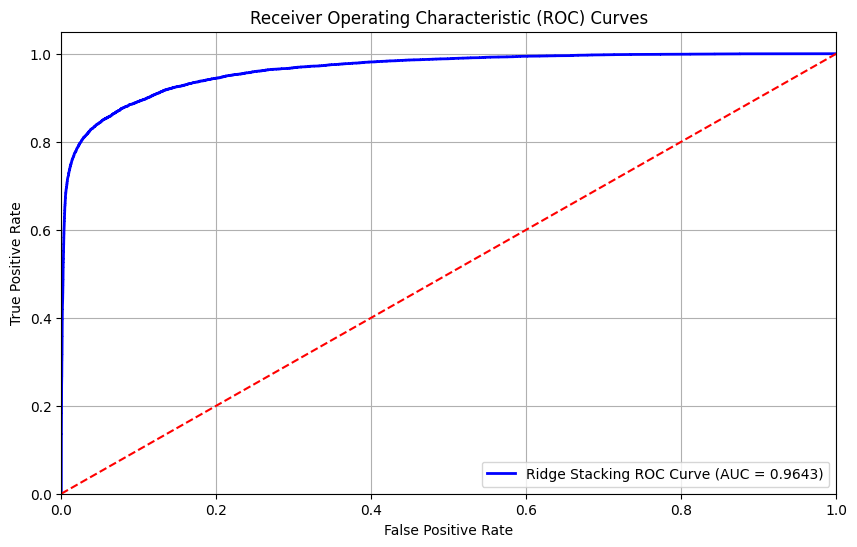

In [85]:
from sklearn.metrics import roc_curve, auc

fpr_ridge, tpr_ridge, _ = roc_curve(ridge_true_labels, ridge_predictions)
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)

plt.figure(figsize=(10, 6))
plt.plot(fpr_ridge, tpr_ridge, color='blue', lw=2, label=f'Ridge Stacking ROC Curve (AUC = {roc_auc_ridge:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Save results

In [86]:
df_sub[target] = ridge_stacking_test_preds

In [87]:
df_sub.head()

,id,loan_status
0,58645,1.014474
1,58646,0.014831
2,58647,0.532114
3,58648,0.004345
4,58649,0.062567


In [88]:
df_sub.to_csv('submission.csv', index=False)